<a href="https://colab.research.google.com/github/PacoPacorius/MedMNIST-Image-Analysis-w-CNNs-and-Transformers---DL-assignment/blob/master/deep_learning_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
!pip install medmnist

In [53]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator, ChestMNIST

dataset = ChestMNIST(split="val", download=True, size=28)

download = True
data_flag = 'chestmnist'

info = INFO[data_flag]['label']
dataset.montage(length=1)

DataClass = getattr(medmnist, INFO[data_flag]['python_class'])

# preprocessing
#data_transform = transforms.Compose([
#    transforms.ToTensor(),
#    transforms.Normalize(mean=[.5], std=[.5])
#])

train_dataset = medmnist.ChestMNIST(split='train', download=download)
val_dataset = medmnist.ChestMNIST(split='val', download=download)
test_dataset = medmnist.ChestMNIST(split='test', download=download)

print(f"--- Dataset: {data_flag} ---")
print(f"Number of training images: {len(train_dataset)}")
print(f"Number of validation images: {len(val_dataset)}")
print(f"Number of test images: {len(test_dataset)}")
print("-" * 40)

print(info)

--- Dataset: chestmnist ---
Number of training images: 78468
Number of validation images: 11219
Number of test images: 22433
----------------------------------------
{'0': 'atelectasis', '1': 'cardiomegaly', '2': 'effusion', '3': 'infiltration', '4': 'mass', '5': 'nodule', '6': 'pneumonia', '7': 'pneumothorax', '8': 'consolidation', '9': 'edema', '10': 'emphysema', '11': 'fibrosis', '12': 'pleural', '13': 'hernia'}


In [59]:
# --- Code to count images per class ---

def count_medmnist_labels(dataset_list, info):
    all_labels = []
    label_names = []
    for dataset in dataset_list:
        # Each dataset.labels is a numpy array where rows are images
        # and columns correspond to the 14 classes (0 for absence, 1 for presence)
        all_labels.append(dataset.labels)

    # Concatenate all label arrays vertically to get one big array of all labels
    combined_labels = np.vstack(all_labels)

    # Sum along the columns to get the total count for each class across all images.
    # Since labels are 0s and 1s, sum gives the number of images tagged with that class.
    class_counts = combined_labels.sum(axis=0)
    label_names.extend(info)


    # Create a dictionary for easier readability
    counts_dict = {name: int(count) for name, count in zip(label_names, class_counts)}
    return counts_dict

# Perform the counting on the combined training, validation, and test sets
all_datasets = [train_dataset, val_dataset, test_dataset]
label_counts = count_medmnist_labels(all_datasets, info)
info = INFO[data_flag]['label']
print("\nNumber of images tagged with each class (across Train + Val + Test sets):")
for class_name, count in label_counts.items():
    print(f"- {class_name:<20}: {count} images")

print("\nNote: ChestMNIST is a multi-label dataset, meaning one image can be associated with multiple classes.")
print("The counts above reflect the total occurrences of each tag.")

# --- Optional: Count for just the training set ---
print("\n--- Optional: Counts for Training Set Only ---")
train_label_counts = count_medmnist_labels([train_dataset], info)
for class_name, count in train_label_counts.items():
    print(f"- {class_name:<20}: {count} images")



Number of images tagged with each class (across Train + Val + Test sets):
- 0                   : 11535 images
- 1                   : 2772 images
- 2                   : 13307 images
- 3                   : 19870 images
- 4                   : 5746 images
- 5                   : 6323 images
- 6                   : 1353 images
- 7                   : 5298 images
- 8                   : 4667 images
- 9                   : 2303 images
- 10                  : 2516 images
- 11                  : 1686 images
- 12                  : 3385 images
- 13                  : 227 images

Note: ChestMNIST is a multi-label dataset, meaning one image can be associated with multiple classes.
The counts above reflect the total occurrences of each tag.

--- Optional: Counts for Training Set Only ---
- 0                   : 7996 images
- 1                   : 1950 images
- 2                   : 9261 images
- 3                   : 13914 images
- 4                   : 3988 images
- 5                   : 437

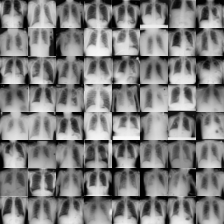

In [55]:
train_dataset.montage(8)